In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import importlib
import os
from tqdm.notebook import tqdm
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [4]:
import matplotlib as mpl
plt.style.use(['dark_background'])
mpl.rcParams['axes.facecolor'] = (27/256, 27/256, 27/256)
mpl.rcParams['figure.facecolor'] = (27/256, 27/256, 27/256)
mpl.rcParams['legend.facecolor'] = (50/256, 50/256, 50/256)
mpl.rcParams['savefig.facecolor'] = (27/256, 27/256, 27/256)
data_color = (0.2, 0.7, 1.0, 1.0)
samp_color = (1.0, 0.7, 0.1, 0.6)
aux_color =(0, 0.9, 0.0, 0.6)

In [5]:
# mpl.rcdefaults()

In [6]:
device = torch.device('cuda:0')

In [7]:
torch.cuda.get_device_name(torch.device('cuda:0'))

'NVIDIA GeForce GTX 1070'

In [8]:
class ConditionalFunc(torch.nn.Module):
    def __init__(self):
        super(ConditionalFunc, self).__init__()

    def forward(self, x): 
        # Average over discharge currents
        E_modified = (x[:, 133:183].mean(dim=1) - ((1100 - torch.tensor(mean[0], device=device, requires_grad=True)) / 
                                                   torch.tensor(ptp[0], device=device, requires_grad=True)))
        E_modified = E_modified.pow(2) * 0.001
        return E_modified
    
def conditional_sampler(x):
    conditional_func = ConditionalFunc().cuda()

    E_model = model(x)
    E_conditional = conditional_func(x)
    print("model: ")
    print(E_model[0:2])
    print("conditional: ")
    print(E_conditional[0:2])
    return E_model + E_conditional

In [9]:
def sample_langevin_cuda_tqdm(x, model, sample_steps=10, step_size=10, noise_scale=0.005, conditional_mask=None):
    if conditional_mask is None:
        conditional_mask = torch.ones((1, x.shape[1]), device=device)
    for _ in tqdm(range(sample_steps)):
        noise = torch.randn_like(x) * noise_scale
        model_output = model(x + noise)
        # Only inputs so that only grad wrt x is calculated (and not all remaining vars)
        gradient = torch.autograd.grad(model_output.sum(), x, only_inputs=True)[0]
        x = x - gradient * step_size * conditional_mask
    return x

In [10]:
data_all = np.load("data/data-MSI-hairpin_002.npz")['signals']
data_valid = np.load("data/data-MSI-hairpin_002-valid.npz")['signals']

In [11]:
data_valid.shape

(36657, 1715)

In [12]:
# model_path = "2021-11-03_11h-42m-33s"
model_path = "2022-03-29_13h-39m-31s"
model_version = "checkpoints/model-300"

spec = importlib.util.spec_from_file_location("msi_ebm_copy", "experiments_msi/" + model_path + "/msi_ebm_copy.py")
ebm = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ebm)
sample_langevin = ebm.sample_langevin
sample_langevin_cuda = ebm.sample_langevin_cuda
ReplayBuffer = ebm.ReplayBuffer
try:
    perturb_samples = ebm.perturb_samples
except:
    pass

model = ebm.NeuralNet().to(device)
ckpt = torch.load("experiments_msi/" + model_path + "/" + model_version + ".pt")
model.load_state_dict(ckpt['model_state_dict'], strict=False)
# data = torch.tensor(np.load("data/isat_downsampled_8_div3.npz")['arr_0'].reshape(-1, 10)).float()

data_path = "data/data-MSI-hairpin_002-train.npz"
data = ebm.load_data(data_path)
mean = np.load(data_path)['mean']
ptp = np.load(data_path)['ptp']

replay_buffer = ReplayBuffer(ckpt['replay_buffer_list'].shape[0], np.random.randn(*data.shape))
replay_buffer.sample_list = ckpt['replay_buffer_list']
print("Number of parameters: {}".format(np.sum([p.numel() for p in model.parameters() if p.requires_grad])))

/home/phil/anaconda3/envs/python3.9/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Number of parameters: 250289


# Conditional sampling

In [13]:
n_samp = 256
steps = 100
step_size = 1e2
noise = 0.005

# data_valid_idx = 15000
data_valid_idx = 22000

samp_begin = 256 * 5
samp_end = 256 * 6

data_samps = torch.tensor(data_valid[data_valid_idx], device=device).repeat((n_samp, 1))
data_samps[:, samp_begin:samp_end] = torch.rand((n_samp, samp_end - samp_begin), requires_grad=True).to(device) * 2 - 1
# samps = perturb_samples(samps)
conditional_mask = torch.zeros((1, 1715), device=device)
conditional_mask[:, samp_begin:samp_end] = torch.ones((1, samp_end - samp_begin), device=device)

for i in tqdm(range(2)):
    data_samps[:, samp_begin:samp_end] = perturb_samples(data_samps[:, samp_begin:samp_end])
    data_samps = sample_langevin_cuda_tqdm(data_samps, model, step_size=step_size, sample_steps=steps,
                                      noise_scale=noise, conditional_mask=conditional_mask)
data_samps = sample_langevin_cuda_tqdm(data_samps, model, step_size=step_size, sample_steps=steps,
                                      noise_scale=noise, conditional_mask=conditional_mask)
    
data_samps = data_samps.to('cpu').detach().numpy()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

## samples

### plot all diagnostics

In [30]:
replay_buffer.sample(256)

tensor([[-0.1558, -0.0495, -0.0402,  ..., -0.1497,  0.3354, -0.0544],
        [ 0.1800, -0.3875, -0.3456,  ..., -0.1564, -0.3149, -0.0596],
        [-0.0258,  0.0294,  0.0373,  ..., -2.5028, -0.4976, -0.5740],
        ...,
        [ 0.1084, -0.2190,  0.0217,  ...,  4.9605, -0.0798, -3.8382],
        [ 0.3214, -0.0605,  0.1850,  ...,  0.3027, -0.2534, -0.9621],
        [ 0.2257,  0.2189, -0.4144,  ..., -0.6868,  0.1335, -1.6662]],
       device='cuda:0')

<IPython.core.display.Javascript object>


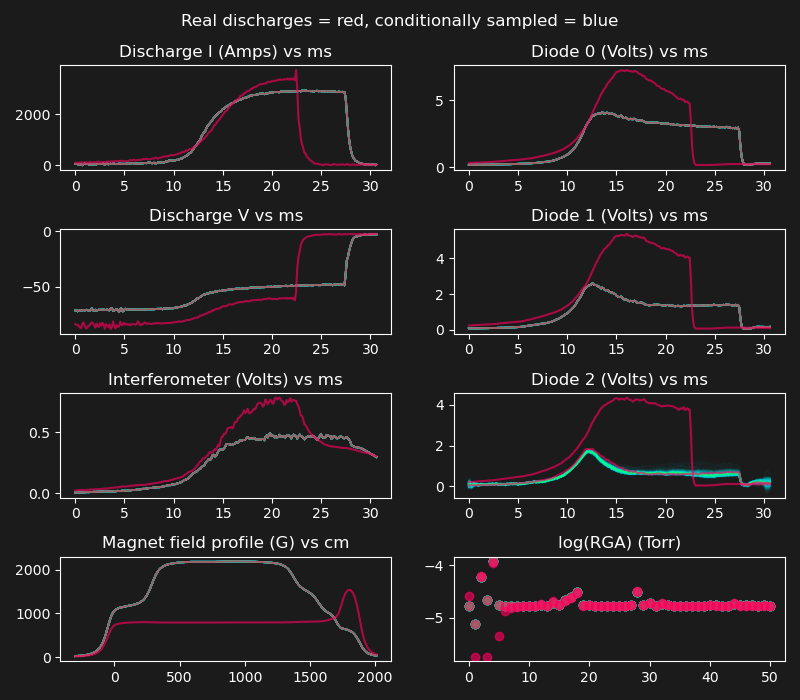

In [17]:
# can disable autoscale from data_samps by making them twin axes:
# https://stackoverflow.com/questions/7386872/make-matplotlib-autoscaling-ignore-some-of-the-plots

colors=['#ff005ca0', '#eb6a7d', '#cd98a1', '#9dbfc6', '#00ff80ff', '#00e2ed0b']

# data_sub_samps=replay_buffer.sample(256).to('cpu').numpy()
# data_sub_samps=data[np.random.randint(0, data.shape[0], 256)].to('cpu').numpy()
data_sub_samps = data_samps[:]
data_samps_mean = np.mean(data_sub_samps, axis=0)
data_samps_std = np.std(data_sub_samps, axis=0)

fig, axes = plt.subplots(4,2, figsize=(8,7), dpi=100)

for ax in axes.flatten():
    ax.set_autoscale_on(False)

for i in range(data_samps.shape[0]):
    axes[0, 0].plot(xrange, data_sub_samps[i, 256 * 0:256 * 1] * ptp[0] + mean[0], color=colors[-1], label="Sampled")
    axes[1, 0].plot(xrange, data_sub_samps[i, 256 * 1:256 * 2] * ptp[1] + mean[1], color=colors[-1])
    axes[2, 0].plot(xrange, data_sub_samps[i, 256 * 2:256 * 3] * ptp[2] + mean[2], color=colors[-1])
    axes[0, 1].plot(xrange, data_sub_samps[i, 256 * 3:256 * 4] * ptp[3] + mean[3], color=colors[-1])
    axes[1, 1].plot(xrange, data_sub_samps[i, 256 * 4:256 * 5] * ptp[4] + mean[4], color=colors[-1])
    axes[2, 1].plot(xrange, data_sub_samps[i, 256 * 5:256 * 6] * ptp[5] + mean[5], color=colors[-1])
    axes[3, 0].plot(B_xrange, data_sub_samps[i, 256 * 6:256 * 6 + 128] * ptp[6] + mean[6], color=colors[-1])
    axes[3, 1].scatter(np.arange(51), data_sub_samps[i, -51:] * ptp[7] + mean[7], color=colors[-1])

for ax in axes.flatten():
    ax.set_autoscale_on(True)

axes[0, 0].plot(xrange, data_samps_mean[256 * 0:256 * 1] * ptp[0] + mean[0], color=colors[4], label="Sampled mean")
axes[1, 0].plot(xrange, data_samps_mean[256 * 1:256 * 2] * ptp[1] + mean[1], color=colors[4])
axes[2, 0].plot(xrange, data_samps_mean[256 * 2:256 * 3] * ptp[2] + mean[2], color=colors[4])
axes[0, 1].plot(xrange, data_samps_mean[256 * 3:256 * 4] * ptp[3] + mean[3], color=colors[4])
axes[1, 1].plot(xrange, data_samps_mean[256 * 4:256 * 5] * ptp[4] + mean[4], color=colors[4])
axes[2, 1].plot(xrange, data_samps_mean[256 * 5:256 * 6] * ptp[5] + mean[5], color=colors[4])
axes[3, 0].plot(B_xrange, data_samps_mean[256 * 6:256 * 6 + 128] * ptp[6] + mean[6], color=colors[4])
axes[3, 1].scatter(np.arange(51), data_samps_mean[-51:] * ptp[7] + mean[7], color=colors[4])

axes[0, 0].plot(xrange, data_valid[data_valid_idx, 256 * 0:256 * 1] * ptp[0] + mean[0], color=colors[0])
axes[1, 0].plot(xrange, data_valid[data_valid_idx, 256 * 1:256 * 2] * ptp[1] + mean[1], color=colors[0])
axes[2, 0].plot(xrange, data_valid[data_valid_idx, 256 * 2:256 * 3] * ptp[2] + mean[2], color=colors[0])
axes[0, 1].plot(xrange, data_valid[data_valid_idx, 256 * 3:256 * 4] * ptp[3] + mean[3], color=colors[0])
axes[1, 1].plot(xrange, data_valid[data_valid_idx, 256 * 4:256 * 5] * ptp[4] + mean[4], color=colors[0])
axes[2, 1].plot(xrange, data_valid[data_valid_idx, 256 * 5:256 * 6] * ptp[5] + mean[5], color=colors[0])
axes[3, 0].plot(B_xrange, data_valid[data_valid_idx, 256 * 6:256 * 6 + 128] * ptp[6] + mean[6], color=colors[0])
axes[3, 1].scatter(np.arange(51), data_valid[data_valid_idx, -51:] * ptp[7] + mean[7], color=colors[0])

axes[0, 0].plot(xrange, data_valid[15000, 256 * 0:256 * 1] * ptp[0] + mean[0], color=colors[0])
axes[1, 0].plot(xrange, data_valid[15000, 256 * 1:256 * 2] * ptp[1] + mean[1], color=colors[0])
axes[2, 0].plot(xrange, data_valid[15000, 256 * 2:256 * 3] * ptp[2] + mean[2], color=colors[0])
axes[0, 1].plot(xrange, data_valid[15000, 256 * 3:256 * 4] * ptp[3] + mean[3], color=colors[0])
axes[1, 1].plot(xrange, data_valid[15000, 256 * 4:256 * 5] * ptp[4] + mean[4], color=colors[0])
axes[2, 1].plot(xrange, data_valid[15000, 256 * 5:256 * 6] * ptp[5] + mean[5], color=colors[0])
axes[3, 0].plot(B_xrange, data_valid[15000, 256 * 6:256 * 6 + 128] * ptp[6] + mean[6], color=colors[0])
axes[3, 1].scatter(np.arange(51), data_valid[15000, -51:] * ptp[7] + mean[7], color=colors[0])

axes[0, 0].set_title('Discharge I (Amps) vs ms')
axes[1, 0].set_title('Discharge V vs ms')
axes[2, 0].set_title('Interferometer (Volts) vs ms')
axes[0, 1].set_title('Diode 0 (Volts) vs ms')
axes[1, 1].set_title('Diode 1 (Volts) vs ms')
axes[2, 1].set_title('Diode 2 (Volts) vs ms')
axes[3, 0].set_title('Magnet field profile (G) vs cm')
axes[3, 1].set_title('log(RGA) (Torr)')
plt.suptitle("Real discharges = red, conditionally sampled = blue")
plt.tight_layout()
# plt.savefig('')

### plot one diagnostic

In [21]:
mpl.rcParams.update(mpl.rcParamsDefault)

In [43]:
# colors=['#ff005c', '#eb6a7d', '#cd98a1', '#9dbfc6', '#00e2ed']
# colors=['#ff005ca0', '#eb6a7d', '#cd98a1', '#9dbfc6', '#00ff80ff', '#00e2ed0b']
colors=['#0000ffff', '#ff0000ff', '#ffaa000b']  # Colors for TTF 2022 poster
# saved_idx = [425, 911, 809, 255, 775]

scale_idx = 5
range_begin = 256 * scale_idx
range_end = 256 * (scale_idx+1)

data_sub_samps = data_samps[:, range_begin:range_end]
data_samps_mean = np.mean(data_sub_samps, axis=0)
data_samps_std = np.std(data_sub_samps, axis=0)

idx = np.random.randint(0, data_samps.shape[0])
fig, axes = plt.subplots(2,1, figsize=(6,4), sharex=True)

for i in range(data_sub_samps.shape[0]):
    axes[0].plot(xrange, data_sub_samps[i] * ptp[scale_idx] + mean[scale_idx], color=colors[-1], label="Sampled" if i==0 else None)

axes[0].plot(xrange, data_valid[data_valid_idx, range_begin:range_end] * ptp[scale_idx] + mean[scale_idx], color=colors[0], label="Real")
axes[0].plot(xrange, data_samps_mean * ptp[scale_idx] + mean[scale_idx], color=colors[-2], label="Sampled mean")

for i in range(data_sub_samps.shape[0]):
    axes[1].plot(xrange, (data_sub_samps[i] - data_samps_mean) * ptp[scale_idx] + mean[scale_idx], color=colors[-1])
axes[1].plot(xrange, (data_valid[data_valid_idx, range_begin:range_end] - data_samps_mean) * ptp[scale_idx] + mean[scale_idx], color=colors[0])
axes[1].plot(xrange, np.zeros(256), color=colors[-2])


axes[0].set_title('Diode 1 signal (Volts)')
axes[1].set_title('Real minus sampled')
axes[1].set_xlabel('Time(ms)')
axes[0].legend()
# axes[0].vlines(13.92,-1,10)
# axes[0].set_ylim(-0.6, 6)
# axes[1].vlines(13.92,-1,1)
# axes[1].set_ylim(-0.6, 0.6)
plt.tight_layout()
# plt.show()
plt.savefig('reconstruction-ttf-2022.pdf')

## sample distribution about mean

<IPython.core.display.Javascript object>


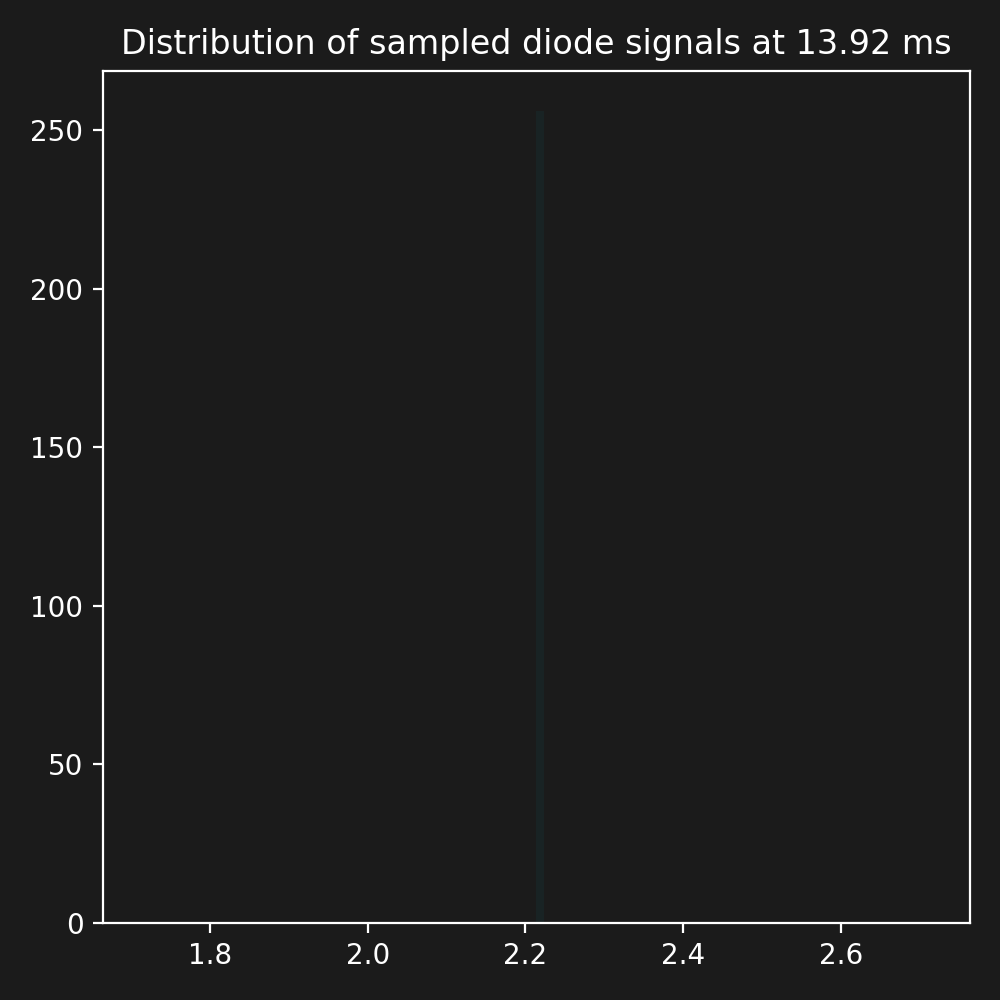

In [28]:
plt.figure(figsize=(5, 5))
plt.hist(np.clip(data_samps[:, 256 * 4:256 * 5][:, 116],-100.81, 100.85) * ptp[4], bins=100, color=colors[-1]);
plt.title('Distribution of sampled diode signals at 13.92 ms')
plt.tight_layout()
# plt.savefig('sample-distribution-talk.pdf')
# 116 = 13.92 ms

# Unconditional sampling

In [116]:
n_samp = 1024
steps = 50
step_size = 1e2
noise = 0.005

samps = torch.rand((n_samp, 1715), requires_grad=True).to(device) * 2 - 1
# samps = perturb_samples(samps)

for i in tqdm(range(3)):
    samps = perturb_samples(samps)
    samps = sample_langevin_cuda_tqdm(samps, model, step_size=step_size, sample_steps=steps,
                                      noise_scale=noise)
samps = sample_langevin_cuda_tqdm(samps, model, step_size=step_size, sample_steps=steps,
                                      noise_scale=noise)
    
samps = samps.to('cpu').detach().numpy()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [179]:
n_samp = 8192
steps = 50
step_size = 1e2
noise = 0.005

aug_steps = 100

data.requires_grad=True
# torch.tensor(replay_buffer.sample_list[0:n_samp], requires_grad=True).float()

temp_buffer = ReplayBuffer(8192, (torch.rand((8192, 1715)) * 2 - 1).to(device))
for i in tqdm(range(200)):
    buf_samp = temp_buffer.sample(int(256 * 0.99))
    if i % aug_steps == 0:
        perturb_samples(buf_samp)
    buf_rand = torch.rand((256 - buf_samp.shape[0], 1715)).to(device) * 2 - 1
    buf_samp = torch.cat([buf_samp, buf_rand], 0).to(device)
    buf_samp = buf_samp.requires_grad_()
    samples = sample_langevin_cuda(buf_samp, model, step_size=step_size, sample_steps=steps, noise_scale=noise)
#     samples = sample_langevin(buf_samp, model, step_size=step_size, sample_steps=steps, noise_scale=noise)
#     print(model(buf_samp[0:3]))
    temp_buffer.add(samples)
samples = sample_langevin_cuda(temp_buffer.sample_list.requires_grad_(), model, step_size=step_size,
                          sample_steps=5, noise_scale=noise)
# samples = sample_langevin(temp_buffer.sample_list.requires_grad_(), model, step_size=step_size,
#                           sample_steps=1, noise_scale=noise)
# temp_buffer.add(samples)
# buf_samp = temp_buffer.sample(n_samp)
buf_samp = samples[:n_samp].detach().cpu().numpy()

  0%|          | 0/200 [00:00<?, ?it/s]

In [164]:
# np.savez("samples/" + model_path + "--" + model_version[12:] + "--iter-{}_steps-{}_aug-{}".format(i, steps, aug_steps), buf_samp=samples.detach().cpu().numpy())

In [84]:
# buf_samp = np.load("samples/2021-11-01_23h-06m-15s--model-100--iter-199_steps-50.npz")['buf_samp']

## Energy histogram

<IPython.core.display.Javascript object>


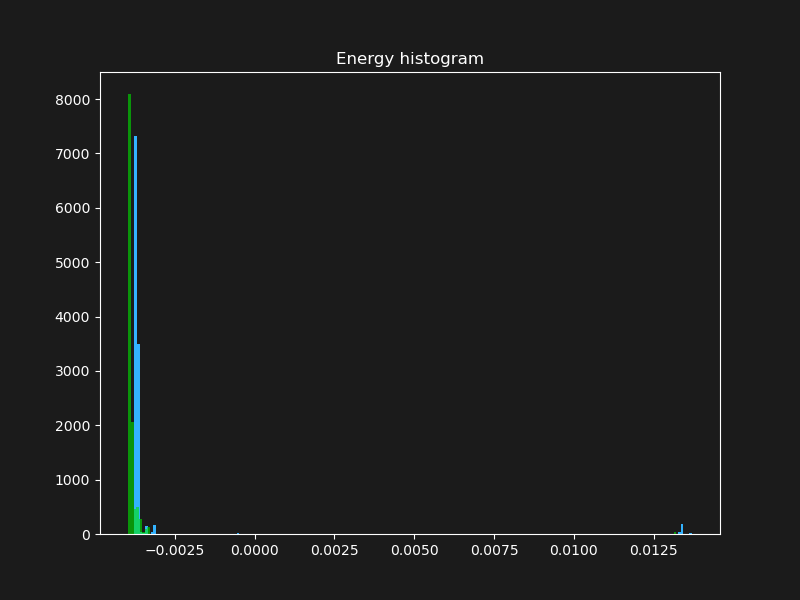

In [351]:
n_bins = 201
fig, axes = plt.subplots(1, 1, figsize=(8,6))
plt.title('Energy histogram')
axes.hist(model(data[np.random.randint(0, data.shape[0], 2000)].to(device)).to('cpu').detach().numpy(),
          bins=n_bins, density=True, color=data_color);
# axes.hist(np.clip(model(torch.tensor(buf_samp, device=device)).to('cpu').detach().numpy(), -1000.1, 1000.04), bins=n_bins, density=True,
#                color=samp_color);
# axes.hist(model(replay_buffer.sample_list[:400].to(device)).to('cpu').detach().numpy(), bins=n_bins, density=True,
#                color=(0, 0.9, 0.0, 0.6));
axes.hist(model(torch.tensor(data_samps).to(device)).to('cpu').detach().numpy(), bins=n_bins, density=True,
               color=aux_color);
# plt.savefig("experiments_msi/" + model_path + '/energy_hist.png', facecolor=(27/256, 27/256, 27/256))

In [231]:
good_buf_samp = buf_samp[np.where(np.abs(model(torch.tensor(buf_samp, device=device)).detach().cpu().numpy()) < 0.001)[0]]
print(good_buf_samp.shape)

(5247, 1715)


In [136]:
saved_idx

[425, 911, 809, 255, 775]

color pallet webiste: #00d9ff, #ff005c

In [146]:
free_plotted_samps = samps

In [329]:
zip([4, 1], [colors[0], colors[4]])

## Samples

<IPython.core.display.Javascript object>


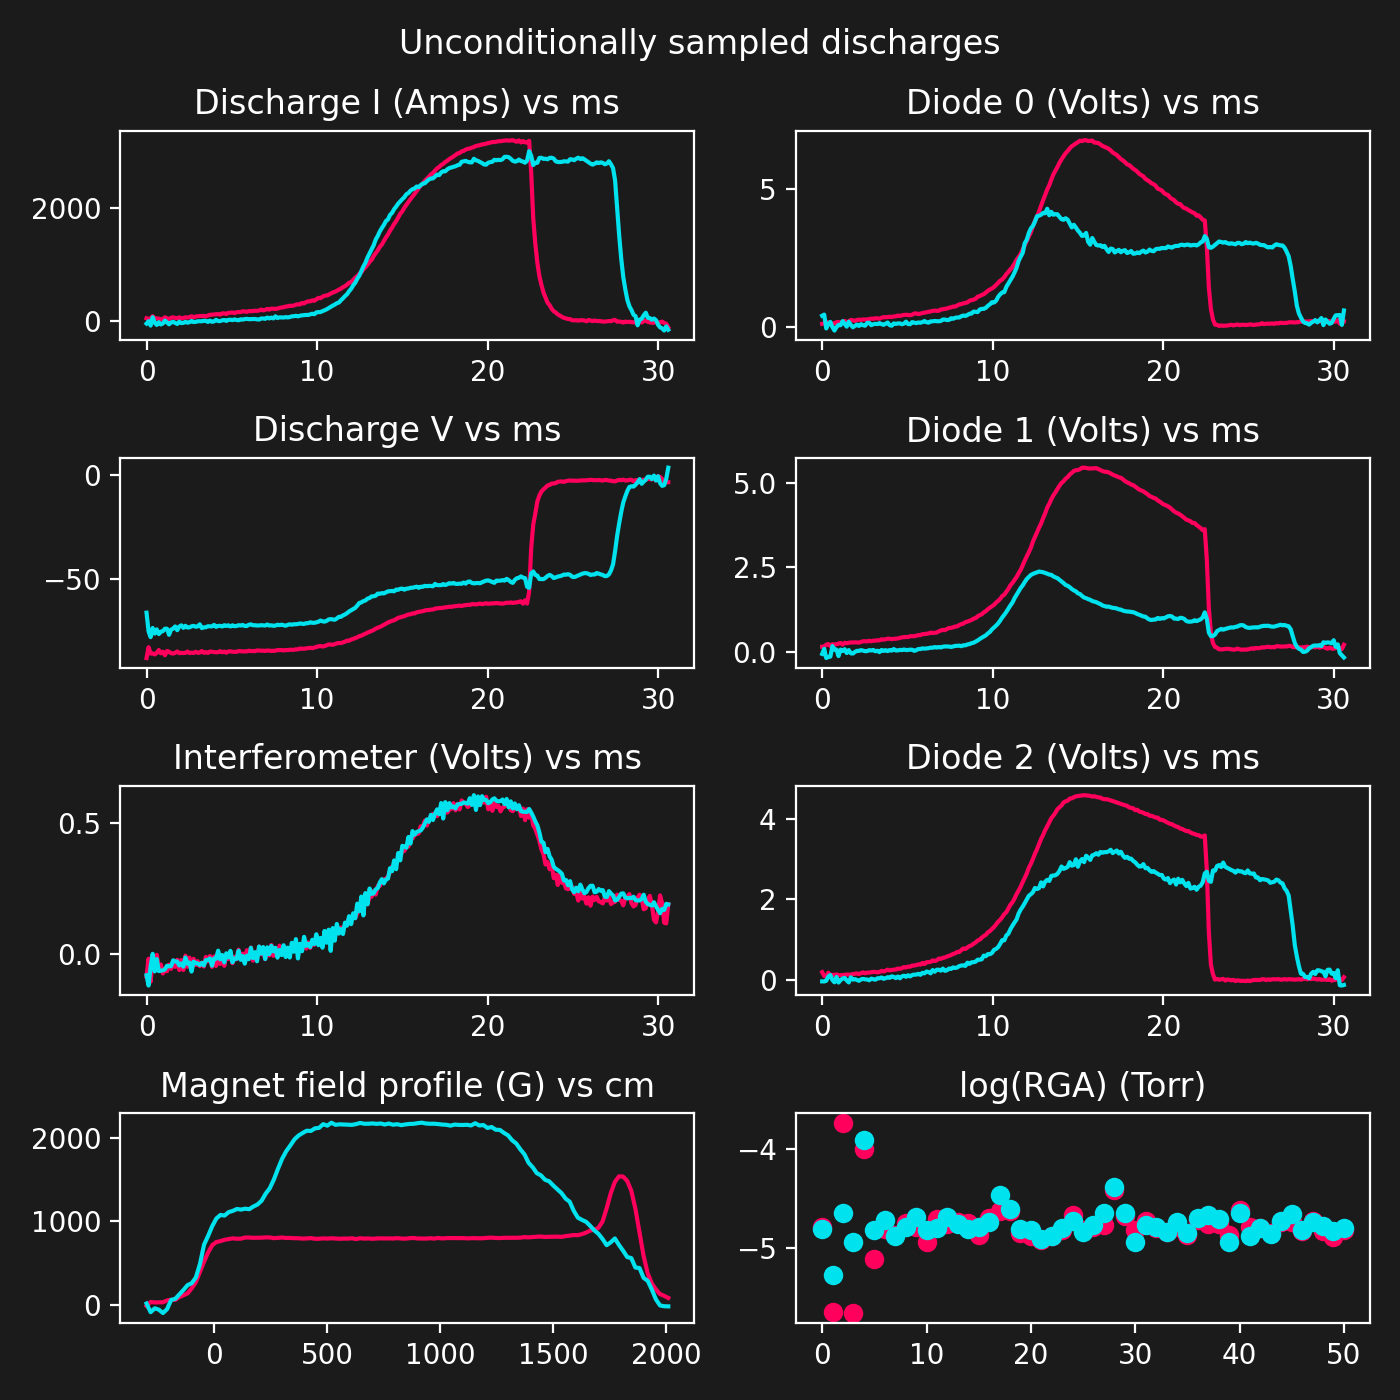

In [334]:
colors=['#ff005c', '#eb6a7d', '#cd98a1', '#9dbfc6', '#00e2ed']
saved_idx = [425, 911, 809, 255, 775]
# idx = np.random.randint(0, samps.shape[0])
fig, axes = plt.subplots(4,2, figsize=(7,7))
for idx, col in zip([4, 1], [colors[0], colors[4]]):
#     col = colors[(idx-4)*-4//3]
#     idx += np.random.randint(0, samps.shape[0])
#     saved_idx.append(idx)
    idx=saved_idx[idx]
    axes[0, 0].plot(xrange, samps[idx, 256 * 0:256 * 1] * ptp[0] + mean[0], color=col)
    axes[1, 0].plot(xrange, samps[idx, 256 * 1:256 * 2] * ptp[1] + mean[1], color=col)
    axes[2, 0].plot(xrange, samps[idx, 256 * 2:256 * 3] * ptp[2] + mean[2], color=col)
    axes[0, 1].plot(xrange, samps[idx, 256 * 3:256 * 4] * ptp[3] + mean[3], color=col)
    axes[1, 1].plot(xrange, samps[idx, 256 * 4:256 * 5] * ptp[4] + mean[4], color=col)
    axes[2, 1].plot(xrange, samps[idx, 256 * 5:256 * 6] * ptp[5] + mean[5], color=col)
    axes[3, 0].plot(B_xrange, samps[idx, 256 * 6:256 * 6 + 128] * ptp[6] + mean[6], color=col)
    axes[3, 1].scatter(np.arange(51), samps[idx, -51:] * ptp[7] + mean[7], color=col)

plt.suptitle("Unconditionally sampled discharges")
# plt.tight_layout()

axes[0, 0].set_title('Discharge I (Amps) vs ms')
axes[1, 0].set_title('Discharge V vs ms')
axes[2, 0].set_title('Interferometer (Volts) vs ms')
axes[0, 1].set_title('Diode 0 (Volts) vs ms')
axes[1, 1].set_title('Diode 1 (Volts) vs ms')
axes[2, 1].set_title('Diode 2 (Volts) vs ms')
axes[3, 0].set_title('Magnet field profile (G) vs cm')
axes[3, 1].set_title('log(RGA) (Torr)')
plt.tight_layout()
plt.savefig("sampled-discharges.pdf")
# plt.savefig("experiments_msi/" + model_path + '/example_discharge.pdf')#, facecolor=(27/256, 27/256, 27/256))

## MSI histograms

<IPython.core.display.Javascript object>


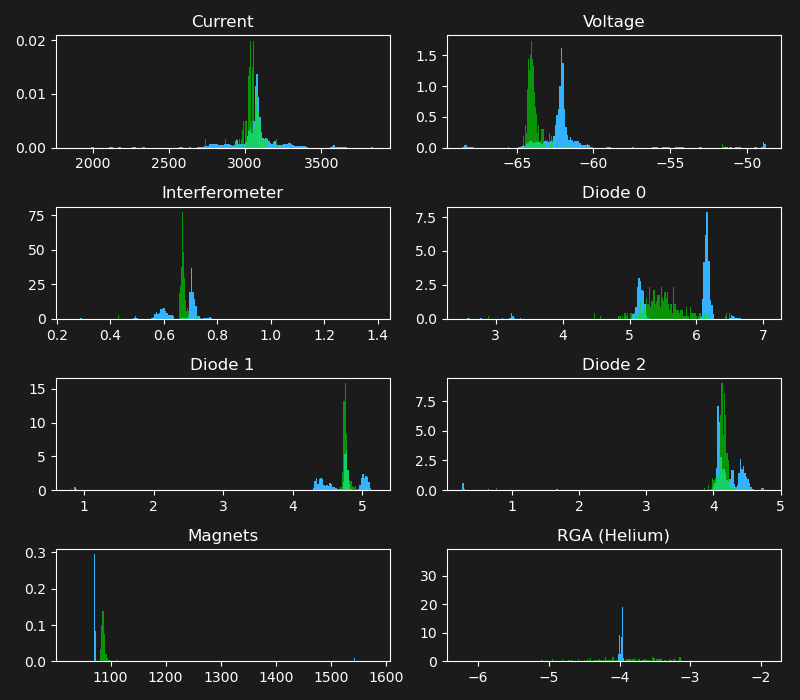

In [352]:
n_bins = 200

fig, axes = plt.subplots(4,2, figsize=(8,7))
axes[0, 0].hist(np.mean(data[:, 256 * 0:256 * 1].detach().numpy()[:, 133:183], axis=1) * ptp[0] + mean[0], bins=n_bins, density=True, color=data_color)
axes[0, 1].hist(np.mean(data[:, 256 * 1:256 * 2].detach().numpy()[:, 133:183], axis=1) * ptp[1] + mean[1], bins=n_bins, density=True, color=data_color)
axes[1, 0].hist(np.mean(data[:, 256 * 2:256 * 3].detach().numpy()[:, 133:183], axis=1) * ptp[2] + mean[2], bins=n_bins, density=True, color=data_color)
axes[1, 1].hist(np.mean(data[:, 256 * 3:256 * 4].detach().numpy()[:, 133:183], axis=1) * ptp[3] + mean[3], bins=n_bins, density=True, color=data_color)
axes[2, 0].hist(np.mean(data[:, 256 * 4:256 * 5].detach().numpy()[:, 133:183], axis=1) * ptp[4] + mean[4], bins=n_bins, density=True, color=data_color)
axes[2, 1].hist(np.mean(data[:, 256 * 5:256 * 6].detach().numpy()[:, 133:183], axis=1) * ptp[5] + mean[5], bins=n_bins, density=True, color=data_color)
axes[3, 0].hist(np.std(data[:, 256 * 6:256 * 6 + 128].detach().numpy(), axis=1) * ptp[6] + mean[6], bins=n_bins, density=True, color=data_color)
axes[3, 1].hist(data[:, 1715-51+4].detach().numpy() * ptp[7] + mean[7], bins=n_bins, density=True, color=data_color)

# axes[0, 0].hist(np.mean(buf_samp[:, 256 * 0:256 * 1][:, 133:183], axis=1) * ptp[0] + mean[0], bins=n_bins, density=True, color=samp_color)
# axes[0, 1].hist(np.mean(buf_samp[:, 256 * 1:256 * 2][:, 133:183], axis=1) * ptp[1] + mean[1], bins=n_bins, density=True, color=samp_color)
# axes[1, 0].hist(np.mean(buf_samp[:, 256 * 2:256 * 3][:, 133:183], axis=1) * ptp[2] + mean[2], bins=n_bins, density=True, color=samp_color)
# axes[1, 1].hist(np.mean(buf_samp[:, 256 * 3:256 * 4][:, 133:183], axis=1) * ptp[3] + mean[3], bins=n_bins, density=True, color=samp_color)
# axes[2, 0].hist(np.mean(buf_samp[:, 256 * 4:256 * 5][:, 133:183], axis=1) * ptp[4] + mean[4], bins=n_bins, density=True, color=samp_color)
# axes[2, 1].hist(np.mean(buf_samp[:, 256 * 5:256 * 6][:, 133:183], axis=1) * ptp[5] + mean[5], bins=n_bins, density=True, color=samp_color)
# axes[3, 0].hist(np.std(buf_samp[:, 256 * 6:256 * 6 + 128], axis=1) * ptp[6] + mean[6], bins=n_bins, density=True, color=samp_color)
# axes[3, 1].hist(buf_samp[:, 1715-51+4] * ptp[7] + mean[7], bins=n_bins, density=True, color=samp_color)

axes[0, 0].hist(np.mean(data_samps[:, 256 * 0:256 * 1][:, 133:183], axis=1) * ptp[0] + mean[0], bins=n_bins, density=True, color=aux_color)
axes[0, 1].hist(np.mean(data_samps[:, 256 * 1:256 * 2][:, 133:183], axis=1) * ptp[1] + mean[1], bins=n_bins, density=True, color=aux_color)
axes[1, 0].hist(np.mean(data_samps[:, 256 * 2:256 * 3][:, 133:183], axis=1) * ptp[2] + mean[2], bins=n_bins, density=True, color=aux_color)
axes[1, 1].hist(np.mean(data_samps[:, 256 * 3:256 * 4][:, 133:183], axis=1) * ptp[3] + mean[3], bins=n_bins, density=True, color=aux_color)
axes[2, 0].hist(np.mean(data_samps[:, 256 * 4:256 * 5][:, 133:183], axis=1) * ptp[4] + mean[4], bins=n_bins, density=True, color=aux_color)
axes[2, 1].hist(np.mean(data_samps[:, 256 * 5:256 * 6][:, 133:183], axis=1) * ptp[5] + mean[5], bins=n_bins, density=True, color=aux_color)
axes[3, 0].hist(np.std(data_samps[:, 256 * 6:256 * 6 + 128], axis=1) * ptp[6] + mean[6], bins=n_bins, density=True, color=aux_color)
axes[3, 1].hist(data_samps[:, 1715-51+4] * ptp[7] + mean[7], bins=n_bins, density=True, color=aux_color)


axes[0, 0].set_title('Current')
axes[0, 1].set_title('Voltage')
axes[1, 0].set_title('Interferometer')
axes[1, 1].set_title('Diode 0')
axes[2, 0].set_title('Diode 1')
axes[2, 1].set_title('Diode 2')
axes[3, 0].set_title('Magnets')
axes[3, 1].set_title('RGA (Helium)')
plt.tight_layout()
# plt.savefig("experiments_msi/" + model_path + '/discharge_msi_hist.png', facecolor=(27/256, 27/256, 27/256))

# Real data

In [66]:
data_valid.shape

(36657, 1715)

In [67]:
data.shape

torch.Size([130756, 1715])

In [65]:
data_all.shape

(183281, 1715)

<IPython.core.display.Javascript object>


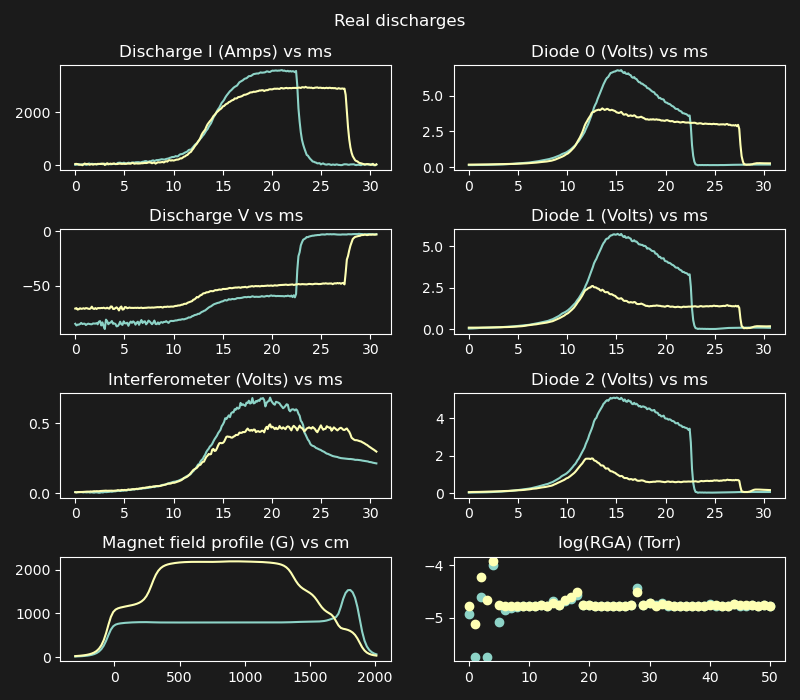

In [91]:
# idx = 10500  # for data_all
idx = 2100  # 2000 is missing both diode 0 and diode 1, starting at 2100: has both
fig, axes = plt.subplots(4,2, figsize=(8,7))
axes[0, 0].plot(xrange, data_valid[idx, 256 * 0:256 * 1] * ptp[0] + mean[0])
axes[1, 0].plot(xrange, data_valid[idx, 256 * 1:256 * 2] * ptp[1] + mean[1])
axes[2, 0].plot(xrange, data_valid[idx, 256 * 2:256 * 3] * ptp[2] + mean[2])
axes[0, 1].plot(xrange, data_valid[idx, 256 * 3:256 * 4] * ptp[3] + mean[3])
axes[1, 1].plot(xrange, data_valid[idx, 256 * 4:256 * 5] * ptp[4] + mean[4])
axes[2, 1].plot(xrange, data_valid[idx, 256 * 5:256 * 6] * ptp[5] + mean[5])
axes[3, 0].plot(B_xrange, data_valid[idx, 256 * 6:256 * 6 + 128] * ptp[6] + mean[6])
axes[3, 1].scatter(np.arange(51), data_valid[idx, -51:] * ptp[7] + mean[7])

# idx = 71235+82  # for data
idx = 22000  # 22000 for different magnetic field config
axes[0, 0].plot(xrange, data_valid[idx, 256 * 0:256 * 1] * ptp[0] + mean[0])
axes[1, 0].plot(xrange, data_valid[idx, 256 * 1:256 * 2] * ptp[1] + mean[1])
axes[2, 0].plot(xrange, data_valid[idx, 256 * 2:256 * 3] * ptp[2] + mean[2])
axes[0, 1].plot(xrange, data_valid[idx, 256 * 3:256 * 4] * ptp[3] + mean[3])
axes[1, 1].plot(xrange, data_valid[idx, 256 * 4:256 * 5] * ptp[4] + mean[4])
axes[2, 1].plot(xrange, data_valid[idx, 256 * 5:256 * 6] * ptp[5] + mean[5])
axes[3, 0].plot(B_xrange, data_valid[idx, 256 * 6:256 * 6 + 128] * ptp[6] + mean[6])
axes[3, 1].scatter(np.arange(51), data_valid[idx, -51:] * ptp[7] + mean[7])

axes[0, 0].set_title('Discharge I (Amps) vs ms')
axes[1, 0].set_title('Discharge V vs ms')
axes[2, 0].set_title('Interferometer (Volts) vs ms')
axes[0, 1].set_title('Diode 0 (Volts) vs ms')
axes[1, 1].set_title('Diode 1 (Volts) vs ms')
axes[2, 1].set_title('Diode 2 (Volts) vs ms')
axes[3, 0].set_title('Magnet field profile (G) vs cm')
axes[3, 1].set_title('log(RGA) (Torr)')
plt.suptitle("Real discharges")
plt.tight_layout()
# plt.savefig('real-discharges.pdf')

## X axis definitions

In [14]:
xrange = np.linspace(0, 1/(25000/3) * 255 * 1000, 256)
B_xrange = np.array([-300.      , -281.81583 , -263.63168 , -245.44751 , -227.26334 ,
       -209.07918 , -190.89502 , -172.71085 , -154.52669 , -136.34251 ,
       -118.158356,  -99.97419 ,  -81.79002 ,  -63.60586 ,  -45.421696,
        -27.237532,   -9.053368,    9.130797,   27.314962,   45.499126,
         63.683292,   81.867455,  100.05162 ,  118.23579 ,  136.41995 ,
        154.60411 ,  172.78828 ,  190.97244 ,  209.1566  ,  227.34077 ,
        245.52493 ,  263.7091  ,  281.89328 ,  300.07742 ,  318.2616  ,
        336.44577 ,  354.6299  ,  372.8141  ,  390.99826 ,  409.1824  ,
        427.36658 ,  445.55075 ,  463.73492 ,  481.91907 ,  500.10324 ,
        518.2874  ,  536.47156 ,  554.65576 ,  572.8399  ,  591.02405 ,
        609.20825 ,  627.3924  ,  645.57654 ,  663.76074 ,  681.9449  ,
        700.129   ,  718.31323 ,  736.4974  ,  754.6815  ,  772.8657  ,
        791.04987 ,  809.234   ,  827.4182  ,  845.60236 ,  863.78656 ,
        881.9707  ,  900.15485 ,  918.33905 ,  936.5232  ,  954.70734 ,
        972.89154 ,  991.0757  , 1009.2598  , 1027.444   , 1045.6282  ,
       1063.8124  , 1081.9965  , 1100.1807  , 1118.3649  , 1136.549   ,
       1154.7332  , 1172.9174  , 1191.1014  , 1209.2856  , 1227.4698  ,
       1245.6539  , 1263.8381  , 1282.0223  , 1300.2064  , 1318.3906  ,
       1336.5748  , 1354.759   , 1372.9431  , 1391.1273  , 1409.3115  ,
       1427.4956  , 1445.6798  , 1463.864   , 1482.0481  , 1500.2323  ,
       1518.4165  , 1536.6006  , 1554.7848  , 1572.969   , 1591.1531  ,
       1609.3373  , 1627.5215  , 1645.7056  , 1663.8898  , 1682.074   ,
       1700.258   , 1718.4423  , 1736.6265  , 1754.8105  , 1772.9948  ,
       1791.179   , 1809.363   , 1827.5472  , 1845.7314  , 1863.9155  ,
       1882.0997  , 1900.2839  , 1918.468   , 1936.6522  , 1954.8364  ,
       1973.0205  , 1991.2047  , 2009.3889  ])

# Plotting script development

In [61]:
# paths = []
# files = []
filepath = []
for dirpath, dirs, files in os.walk("/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi"):
    for f in files:
        if ".pt" in f:
            filepath.append(os.path.join(dirpath, f))

In [68]:
len('/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/2021-10-27_15h-13m-45s/')

72

In [66]:
len('/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/')

49

In [70]:
'/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/2021-10-27_15h-13m-45s/checkpoints/model-0.pt'[49:71]

'2021-10-27_15h-13m-45s'

In [99]:
filepath[6][72:-3]

'checkpoints/model-50'

In [64]:
sorted(filepath[])

['/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/2021-10-27_15h-13m-45s/checkpoints/model-0.pt',
 '/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/2021-10-27_15h-30m-02s/checkpoints/model-0.pt',
 '/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/2021-10-27_15h-31m-39s/checkpoints/model-0.pt',
 '/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/2021-10-27_15h-38m-11s/checkpoints/model-0.pt',
 '/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/2021-10-27_15h-38m-11s/checkpoints/model-25.pt',
 '/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/2021-10-27_15h-38m-11s/checkpoints/model-50.pt',
 '/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/2021-10-27_15h-46m-18s/checkpoints/model-0.pt',
 '/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/2021-10-27_15h-46m-18s/checkpoints/model-25.pt',
 '/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/2021-10-27_15h-46m-18s/checkpoints/model-50.pt',
 '/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/2021-10-27_18h-07m-44s/checkpoints/model-0.pt',
 '/hom

In [100]:
with open('/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/2022-02-25_17h-06m-25s/msi_ebm_copy.py', 'r') as infile:
    for line in infile:
        if "data_path = " in line:
            print(line[17:-6])
        if "\"step_size\": " in line:
            print(line[21:-2])
        if "\"sample_steps\": " in line:
            print(line[24:-2])
        if "\"noise_scale\": " in line:
            print(line[23:-2])
    

50
1e2
5e-3
data/data-MSI-hairpin_002-train


In [79]:
len("       \"sample_steps\": ")

21

In [82]:
len("        \"step_size\": ")

21

In [83]:
len("        \"noise_scale\": ")

23

In [85]:
len("data_path = \"")

13

In [71]:
!cat '/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/2021-10-27_15h-13m-45s/msi_ebm_copy.py' | grep "data_path = "

    data_path = "data/data-MSI-hairpin_001.npz"


In [104]:
if 'train' in "data/data-MSI-hairpin_002-train.npz":
    print('data/data-MSI-hairpin_002-train.npz'[:-10])

data/data-MSI-hairpin_002


In [105]:
"/home/phil/Desktop/EBMs/lapd-ebm/experiments_msi/2021-10-27_15h-13m-45s/checkpoints/model-50.pt"[-5:-3]

'50'

.





















































.

<generator object _walk at 0x7f572e504660>